<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B8%A5%E0%B8%AD%E0%B8%87%E0%B8%95%E0%B8%B2%E0%B8%A1%E0%B8%9E%E0%B8%B5%E0%B9%88%E0%B8%81%E0%B8%B5%E0%B9%89_2%E0%B8%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [17]:
import pandas as pd
import shutil

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/Data_Male_125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07M,VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
1,2,1,7,Y07M,Flip_VV03.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
2,3,2,7,Y07M,VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
3,4,2,7,Y07M,Flip_VV04.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
4,5,3,7,Y07M,VV05.jpg,/content/drive/My Drive/cut_panoramic/7 year/7...,เพศชาย,Both
...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,Flip_J463.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2371,122,78,25,Y25M,J464.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2372,123,78,25,Y25M,Flip_J464.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both
2373,124,79,25,Y25M,J465.jpg,/content/drive/My Drive/cut_panoramic/25 year/...,เพศชาย,Both


#Imports

In [20]:
import PIL
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
     

#กำหนดค่าพารามิเตอร์


In [21]:
batch_size = 16
width = 150
height = 150
epochs = 250
NUM_TRAIN = 1425
NUM_TEST = 475
dropout_rate = 0.2
input_shape = (height, width, 3) #คือการปิดบาง Node หรือเรียกว่าทำการ Drop Out ไป ซึ่งขึ้นกับการตั้งค่าว่าจะให้ลืมไปกี่เปอร์เซนต์ดี ช่วยในการแก้ปัญหา Overfitting

#Clone efficientnet repo


In [22]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [23]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

##สร้างโฟลเดอร์ Train Valodation และ Test

In [24]:
base_dir = '/content/drive/MyDrive/TVT_Male125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)


#Train

In [25]:
import sys
sys.path.append('/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Male125_250.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [26]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

model_dir = f'/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Male125_250.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

In [27]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1425 images belonging to 19 classes.
Found 473 images belonging to 19 classes.


In [28]:
root_logdir = f'/content/drive/MyDrive/cut_panoramic/Model/รอบแรก_Flimpano_Female125_250.h5'    ##เปลี่ยน path 
if not os.path.exists(root_logdir) :
    os.makedirs(root_logdir)

In [29]:
root_logdir = os.path.join(os.curdir,"my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)
run_logdir = get_run_logdir()

In [30]:
model.trainable = True
set_trainable = False
for layer in model.layers:
     if layer.name == 'block5a_se_excite':
        set_trainable = True
     if set_trainable:
        layer.trainable = True
     else:
        layer.trainable = False
print('This is the number of trainable layers '
        'after freezing the conv base:', len(model.trainable_weights)) 

This is the number of trainable layers after freezing the conv base: 0


In [31]:
model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.RMSprop(lr=2e-5),
                      metrics=['acc'])

run_logdir = get_run_logdir()

tensorboard_cb = callbacks.TensorBoard(run_logdir)
#early_stop_cb = callbacks.EarlyStopping(monitor='val_acc', patience=66, mode= 'max')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [32]:
from tensorflow.keras import callbacks
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), #lr ควรเล็กกว่า retrain1
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks = [tensorboard_cb])

<ipython-input-32-427199de1b5a>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/250
89/89 [==============================] - 86s 855ms/step - loss: 2.3167 - acc: 0.2441 - val_loss: 2.7192 - val_acc: 0.1487
Epoch 2/250
89/89 [==============================] - 75s 826ms/step - loss: 2.3777 - acc: 0.2236 - val_loss: 2.7023 - val_acc: 0.1466
Epoch 3/250
89/89 [==============================] - 77s 850ms/step - loss: 2.3415 - acc: 0.2278 - val_loss: 2.7101 - val_acc: 0.1466
Epoch 4/250
89/89 [==============================] - 77s 837ms/step - loss: 2.3521 - acc: 0.2285 - val_loss: 2.7022 - val_acc: 0.1466
Epoch 5/250
89/89 [==============================] - 83s 917ms/step - loss: 2.3345 - acc: 0.2278 - val_loss: 2.7141 - val_acc: 0.1444
Epoch 6/250
89/89 [==============================] - 78s 854ms/step - loss: 2.3641 - acc: 0.2236 - val_loss: 2.7219 - val_acc: 0.1444
Epoch 7/250
89/89 [==============================] - 79s 865ms/step - loss: 2.3547 - acc: 0.2122 - val_loss: 2.7047 - val_acc: 0.1487
Epoch 8/250
89/89 [==============================] - 76s 836ms

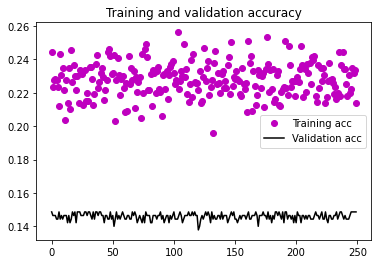

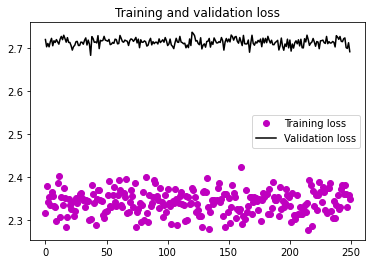

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'mo', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'mo', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Download the model


In [34]:
os.makedirs('/content/drive/My Drive/cut_panoramic/Model', exist_ok=True)
model.save('/content/drive/My Drive/cut_panoramic/Model/ลองรอบสองชาย.h5')

In [38]:
from google.colab import files
files.download('/content/drive/My Drive/cut_panoramic/Model/ลองรอบสองชาย.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>